## Inference: Solar Panel Anomaly Detection on Thermal Orthophoto using Detectron2
This is the solar panel anomaly detection on UAV-captured thermal orthophotos using a trained Detectron2 instance segmentation model. It includes tiling the input image, running predictions, visualizing detected anomalies, exporting results to GeoJSON, and linking anomalies to individual solar panels for further analysis.

### 1. Import Libraries
Import essential libraries for image processing, geospatial data handling, visualization, and deep learning inference using Detectron2.

In [71]:

import os
import cv2
import torch
import numpy as np
import rasterio
from rasterio.windows import Window
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from collections import Counter
import random


## 2. Configuration and Setup
Define file paths, model parameters, tiling settings, and create an output directory for predictions. Clean any previously saved tiles to ensure a fresh start.

In [72]:

# Configuration
orthophoto_path = "ortho/small_area.tif"
tile_size = 512
stride = 512
model_path = "training_data/output/model_final.pth"
cfg_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
score_thresh = 0.5
output_dir = "outputs/tile_predictions"
os.makedirs(output_dir, exist_ok=True)

# Clean old tiles
for f in os.listdir(output_dir):
    os.remove(os.path.join(output_dir, f))


## 3. Tile Generation from Orthophoto
Split the input orthophoto into fixed-size tiles and saves them as individual GeoTIFF files while preserving georeferencing information. Store each tiles metadata for further processing.

In [73]:

tiles_info = []
with rasterio.open(orthophoto_path) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

    for y in range(0, height, stride):
        for x in range(0, width, stride):
            win = Window(x, y, tile_size, tile_size)
            transform_tile = rasterio.windows.transform(win, transform)
            tile_img = src.read(window=win)
            tile_name = f"tile_{x}_{y}.tif"
            tile_path = os.path.join(output_dir, tile_name)
            with rasterio.open(tile_path, "w", driver="GTiff",
                               height=tile_size, width=tile_size,
                               count=3, dtype=tile_img.dtype,
                               crs=crs, transform=transform_tile) as dst:
                dst.write(tile_img)
            tiles_info.append((tile_path, (x, y), transform_tile))


## 4. Model Configuration and Predictor Initialization
Load the Detectron2 configuration, set the trained model weights, define threshold and number of classes, select device (GPU/CPU), and initialize the predictor for inference.

In [74]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(cfg_file))
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)


Some model parameters or buffers are not found in the checkpoint:
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


## 5. Tile Inference and Result Extraction
Perform inference on each image tile using the trained model, extracts predicted masks, bounding boxes, and class information, and convert detections into map-based geometries (both bounding boxes and refined polygons). Save class-wise counts for summary reporting.

In [80]:
 
# Class mapping
class_names = [
    "Single Hotspot", "Multi Hotspots", "Single Diode", "Multi Diode",
    "Single Bypassed Substring", "Multi Bypassed Substring",
    "String (Open Circuit)", "String (Reversed Polarity)"
]

# Store two sets of results
polygon_results = []  # valid polygon shapes
bbox_results = []     # all raw detections (as rectangles)

class_counter = Counter()
polygon_counter = Counter()

for tile_path, (x_offset, y_offset), transform_tile in tqdm(tiles_info):
    with rasterio.open(tile_path) as tile:
        img = tile.read()
        if img.shape[0] == 3:
            img = img.transpose(1, 2, 0)
        else:
            continue

    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")
    masks = instances.pred_masks.numpy()
    scores = instances.scores.numpy()
    class_ids = instances.pred_classes.numpy()
    boxes = instances.pred_boxes.tensor.numpy()

    class_counter.update(class_ids)

    # Save visual prediction
    vis = Visualizer(img[:, :, ::-1], metadata={"thing_classes": class_names}, scale=1.2, instance_mode=ColorMode.IMAGE)
    vis = vis.draw_instance_predictions(instances)
    vis_img = vis.get_image()[:, :, ::-1]
    # save_path = os.path.join(output_dir, f"pred_{x_offset}_{y_offset}.png")
    # cv2.imwrite(save_path, vis_img)

    for i, box in enumerate(boxes):
        class_id = int(class_ids[i])
        score = float(scores[i])
        classname = class_names[class_id]

        # Convert box to map coords
        x0, y0, x1, y1 = box
        bbox_coords = [transform_tile * (x0, y0), transform_tile * (x1, y1)]
        x_min, y_min = bbox_coords[0]
        x_max, y_max = bbox_coords[1]

        # Create bbox polygon (rectangle)
        bbox_poly = Polygon([
            (x_min, y_min), (x_min, y_max),
            (x_max, y_max), (x_max, y_min),
            (x_min, y_min)
        ])

        bbox_results.append({
            "geometry": bbox_poly,
            "score": score*100,
            "class": class_id,
            "classname": classname
        })

        # Extract polygon from mask if possible
        mask = masks[i]
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        max_contour = max(contours, key=cv2.contourArea)
        if len(max_contour) < 3:
            continue

        poly_coords = []
        for pt in max_contour.squeeze():
            col, row = pt
            x, y = transform_tile * (col, row)
            poly_coords.append((x, y))

        polygon = Polygon(poly_coords)
        if not polygon.is_valid or polygon.area == 0:
            continue

        polygon_results.append({
            "geometry": polygon,
            "score": score*100,
            "bbox": [x_min, y_min, x_max, y_max],
            "class": class_id,
            "classname": classname
        })

        polygon_counter[class_id] += 1

# Print summary
print("\n--- Inference Summary ---")
print(f"Total classes detected (raw): {len(class_counter)}")
for class_id, count in class_counter.items():
    print(f"Class {class_id} ({class_names[class_id]}): {count} instances")

print(f"\n--- Final Polygons Saved ---")
print(f"Total polygons: {len(polygon_results)}")
for class_id, count in polygon_counter.items():
    print(f"Class {class_id} ({class_names[class_id]}): {count} polygons")


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:32<00:00,  5.20it/s]


--- Inference Summary ---
Total classes detected (raw): 3
Class 5 (Multi Bypassed Substring): 7 instances
Class 2 (Single Diode): 7 instances
Class 3 (Multi Diode): 8 instances

--- Final Polygons Saved ---
Total polygons: 1
Class 3 (Multi Diode): 1 polygons


## 6. Visualization of Detection Results
Display the orthophoto with detected anomalies overlaid—red outlines for polygon masks and blue dashed outlines for bounding boxes—using matplotlib for visual verification.

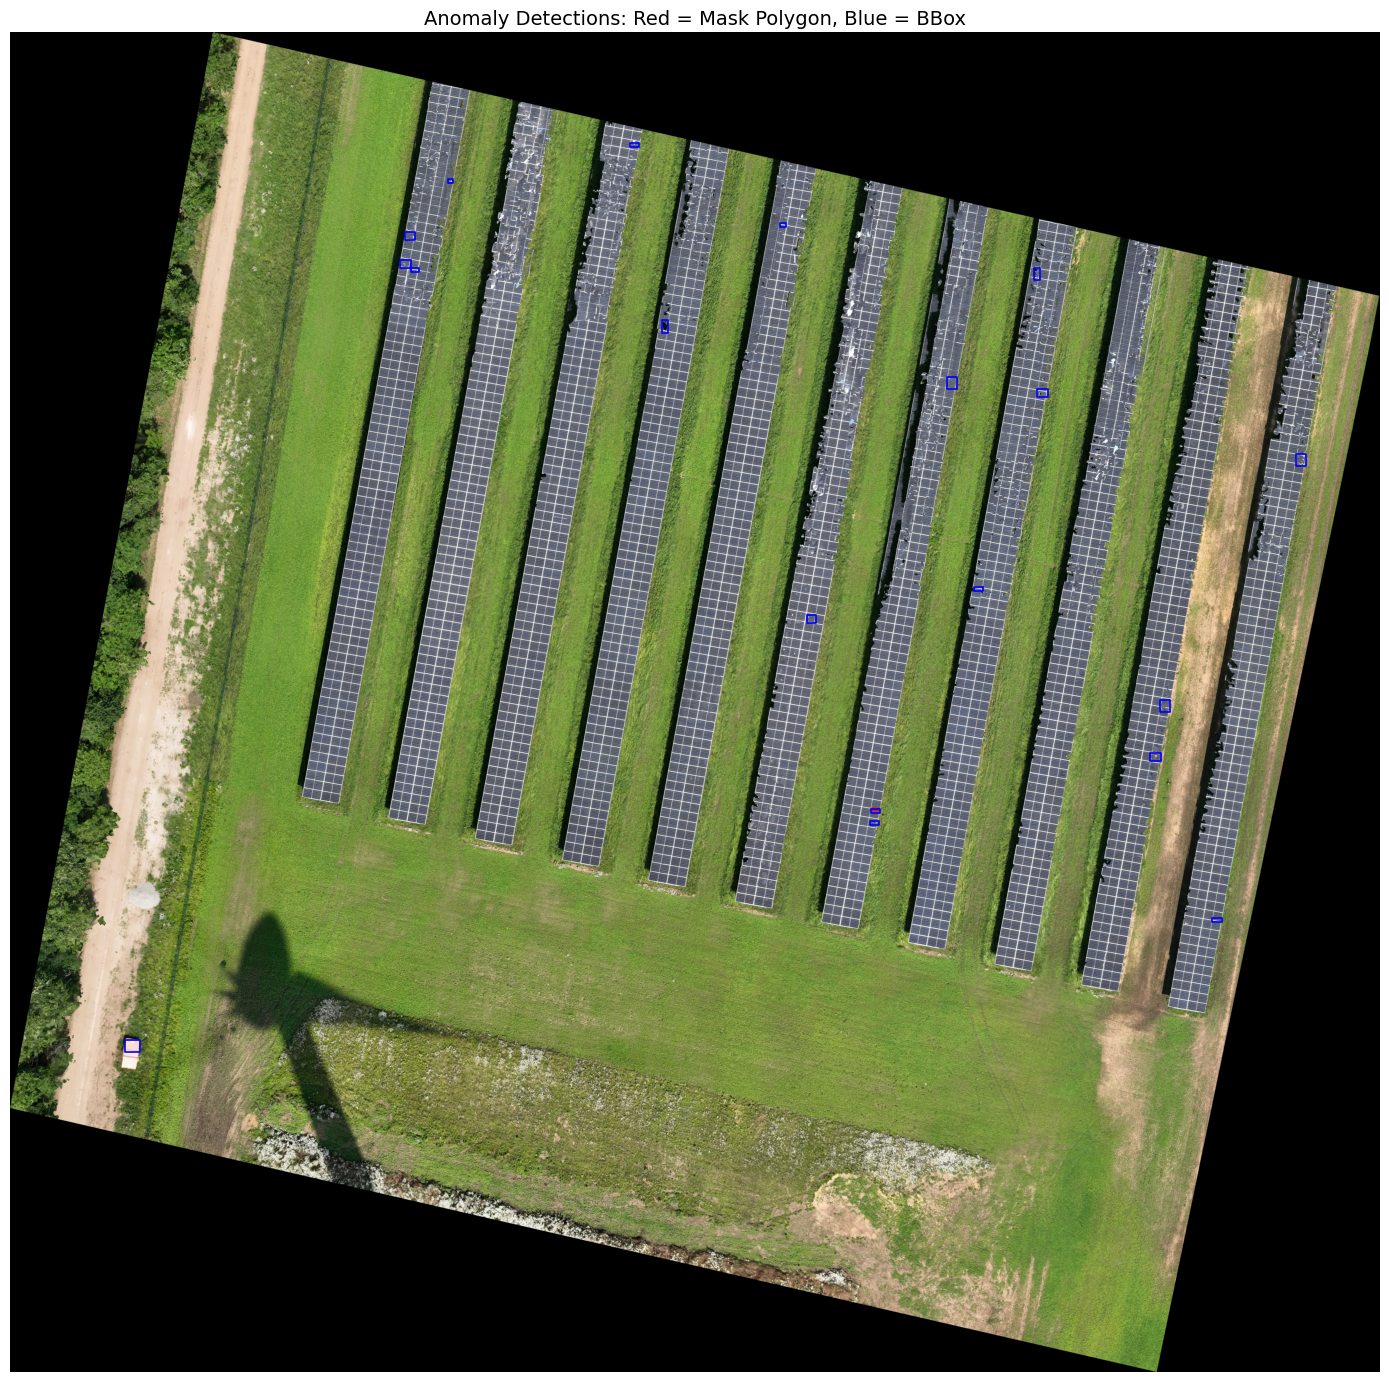

In [76]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon, Rectangle
from matplotlib.collections import PatchCollection

# Read orthophoto
with rasterio.open(orthophoto_path) as src:
    ortho_img = src.read([1, 2, 3])
    ortho_img = np.transpose(ortho_img, (1, 2, 0))  # HWC
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plot
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(ortho_img, extent=extent)

# --- Plot polygons (red outlines) ---
polygon_patches = []
for r in polygon_results:
    geom = r["geometry"]
    if geom and geom.is_valid and not geom.is_empty:
        x, y = geom.exterior.xy
        coords = list(zip(x, y))
        polygon_patches.append(MplPolygon(coords, closed=True))

polygon_collection = PatchCollection(polygon_patches, facecolor='none', edgecolor='red', linewidths=1.2)
ax.add_collection(polygon_collection)

# --- Plot bounding boxes (blue dashed outlines) ---
bbox_patches = []
for r in bbox_results:
    geom = r["geometry"]
    if geom and geom.is_valid and not geom.is_empty:
        x, y = geom.exterior.xy
        coords = list(zip(x, y))
        bbox_patches.append(MplPolygon(coords, closed=True))

bbox_collection = PatchCollection(bbox_patches, facecolor='none', edgecolor='blue', linewidths=1.2)
ax.add_collection(bbox_collection)

# Display
ax.set_title("Anomaly Detections: Red = Mask Polygon, Blue = BBox", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


## 7. Export Polygons and Bboxes to geojson

In [77]:
from shapely.geometry import mapping
import geopandas as gpd

# Export filtered polygons
polygon_gdf = gpd.GeoDataFrame(polygon_results, geometry=[r["geometry"] for r in polygon_results], crs=crs)
polygon_gdf["id"] = range(len(polygon_gdf))
polygon_gdf.to_file("outputs/anomalies_polygons.geojson", driver="GeoJSON")

# Export all bbox detections
bbox_gdf = gpd.GeoDataFrame(bbox_results, geometry=[r["geometry"] for r in bbox_results], crs=crs)
bbox_gdf["id"] = range(len(bbox_gdf))
bbox_gdf.to_file("outputs/anomalies_bbox.geojson", driver="GeoJSON")
print("exported")


## 8. Identify solar id and embed it to anamoly json
Perform a spatial join between detected anomalies and solar panel polygons to assign each anomaly to a solar panel ID, then export a summary of anomalies per panel and class to GeoJSON and CSV files.

In [79]:
import geopandas as gpd
import pandas as pd

# Load solar panel polygons and rename 'id' to 'solar_id'
solar_panels = gpd.read_file("solar_polygon/solar_polygons.geojson")
solar_panels = solar_panels.rename(columns={'id': 'solar_id'})

# Load anomaly polygons
anomalies = gpd.read_file("outputs/anomalies_bbox.geojson")

# Ensure both are in the same CRS
if solar_panels.crs != anomalies.crs:
    solar_panels = solar_panels.to_crs(anomalies.crs)

# Perform spatial join - attaches solar_id to anomalies where overlap occurs
joined = gpd.sjoin(anomalies, solar_panels[['solar_id', 'geometry']], how="left", predicate="intersects")

# Drop helper column if it exists
joined = joined.drop(columns=['index_right'], errors='ignore')

# Save updated GeoJSON with solar_id field
joined.to_file("outputs/anomalies_with_solar_id.geojson", driver="GeoJSON")

# Group and summarize anomaly count per solar panel and class
if 'solar_id' in joined.columns and 'classname' in joined.columns:
    summary = joined.groupby(['solar_id', 'classname', 'score']).size().reset_index(name='num_anomalies')
    summary.to_csv("outputs/anomaly_summary.csv", index=False)
    print(summary.to_string(index=False))
else:
    print("Either 'solar_id' or 'classname' column is missing after join.")


 solar_id                classname     score  num_anomalies
    218.0 Multi Bypassed Substring 53.106499              1
    226.0 Multi Bypassed Substring 58.089930              1
    226.0              Multi Diode 57.805055              1
    226.0              Multi Diode 58.413512              1
    226.0             Single Diode 50.508446              1
    228.0              Multi Diode 61.935216              1
    230.0 Multi Bypassed Substring 54.431117              1
    231.0             Single Diode 53.281283              1
    234.0              Multi Diode 55.051565              1
    239.0 Multi Bypassed Substring 50.201952              1
    239.0 Multi Bypassed Substring 52.389431              1
    239.0              Multi Diode 57.711238              1
    240.0 Multi Bypassed Substring 54.958153              1
    240.0              Multi Diode 58.200586              1
    240.0             Single Diode 50.160486              1
    247.0             Single Diode 51.88